
# Creating Simple Queries to PostgreSQL in Python

This notebook covers the fundamentals of using Python to interact with a PostgreSQL database. We'll explore how to run queries, handle data, and ensure secure database interactions.

## Topics Covered

0. Uploading a CSV file as a new table in the database.
1. Basic SQL queries in Python using SQLite (as a local example before moving to PostgreSQL).
2. Iterating over data using a `SELECT *` statement.
3. Basic `GROUP BY` queries.
4. Using templating to prevent SQL injection.
5. Selecting specific columns and rows, including limiting and offsetting results.
6. Implementing `ORDER BY` in queries.
7. Adding pagination to results using itertools.
8. Loading data into a Pandas DataFrame for analysis and charting.

Each section includes examples and explanations. In the end, you'll find an exercise to apply the concepts learned.


In [3]:
!pip install psycopg2

In [4]:

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Connecting to the PostgreSQL Database

# We'll establish a connection to the PostgreSQL database using psycopg2 library.

DB_HOST = 'test-db-sql-class.cnct5qiopjti.us-east-1.rds.amazonaws.com'
DB_PORT = 5432
DB_NAME = 'students'
DB_USER = 'student'
DB_PASSWORD = 'Password123$'
STUDENT_NAME_TABLE = 'default'  # CHANGE THIS!

try:
    conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)
    print("Connected to the database.")
except psycopg2.Error as e:
    print("Unable to connect to the database.")
    print(e)


Connected to the database.


## 0. Load the Database and Table

In [5]:
%%writefile get_data.sh

mkdir -p data
if [ ! -f ./data/drinks.csv ]; then
    wget -O data/drinks.csv https://www.dropbox.com/scl/fi/tkfdy0mq30g2t424hmn5o/drinks.csv?rlkey=jl8r4aw1o7y7b5au8icub20pn&dl=0
fi

Writing get_data.sh


In [6]:
!bash get_data.sh

--2024-04-02 02:19:05--  https://www.dropbox.com/scl/fi/tkfdy0mq30g2t424hmn5o/drinks.csv?rlkey=jl8r4aw1o7y7b5au8icub20pn
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc88fc83ca1d11a5537c01caa563.dl.dropboxusercontent.com/cd/0/inline/CQNuOjhCvEzD9yLQzs63U95oS5VzxuRE5j6DAbapfAV3t7kMOJprvFAKlfL2uCcoM4UYoQZzqi_mUSLlSIwMFWSysvdrVQKHLnRl3QaaGWov6V5RSUFIwCwAeIUt01ZsAP1Rk6X1HcpudcPOW6dgnQsp/file# [following]
--2024-04-02 02:19:06--  https://uc88fc83ca1d11a5537c01caa563.dl.dropboxusercontent.com/cd/0/inline/CQNuOjhCvEzD9yLQzs63U95oS5VzxuRE5j6DAbapfAV3t7kMOJprvFAKlfL2uCcoM4UYoQZzqi_mUSLlSIwMFWSysvdrVQKHLnRl3QaaGWov6V5RSUFIwCwAeIUt01ZsAP1Rk6X1HcpudcPOW6dgnQsp/file
Resolving uc88fc83ca1d11a5537c01caa563.dl.dropboxusercontent.com (uc88fc83ca1d11a5537c01caa563.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100

In [7]:
# Creating a new table with specified data types
cursor = conn.cursor()
cursor.execute(f"""
CREATE TABLE IF NOT EXISTS drinks_{STUDENT_NAME_TABLE} (
    id SERIAL PRIMARY KEY,
    country VARCHAR(255),
    beer_servings FLOAT,
    spirit_servings FLOAT,
    wine_servings FLOAT,
    total_litres_of_pure_alcohol FLOAT,
    continent VARCHAR(255)
);
""")
# Inserting data from the CSV file
with open('data/drinks.csv', 'r') as file:
    next(file)  # Skip the header
    cursor.copy_from(file, f'drinks_{STUDENT_NAME_TABLE}', sep=',', columns=(
        'country', 'beer_servings', 'spirit_servings', 'wine_servings',
        'total_litres_of_pure_alcohol', 'continent'
    ))

conn.commit()


## 1. Basic SQL Queries Using SQLite
In this section, we'll start with SQLite to demonstrate basic SQL operations in Python.


In [8]:

# Example 1: Creating a table and inserting data
create_table_query = f'''
CREATE TABLE if not exists students_{STUDENT_NAME_TABLE} (
    id serial primary key,
    name TEXT,
    age INTEGER
);
'''

# Execute the query
cur = conn.cursor()
cur.execute(create_table_query)

# Inserting data
insert_query = f"INSERT INTO students_{STUDENT_NAME_TABLE} (name, age) VALUES (%s, %s);"
cur.execute(insert_query, ('Alice', 21))
cur.execute(insert_query, ('Bob', 22))
conn.commit()


In [9]:

# Example 2: Selecting data from the table
select_query = f"SELECT * FROM students_{STUDENT_NAME_TABLE};"
pd.read_sql_query(select_query, conn)


<ipython-input-9-9c67dcdc7711>:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(select_query, conn)


,id,name,age
0,1,Alice,21
1,2,Bob,22
2,3,Alice,21
3,4,Bob,22


### Mini Exercise - Connection and Basic Queries
Connect to the database and perform a simple query to count the number of rows in a specified table (e.g., 'students').

In [ ]:

# Connect to your postgres DB
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)

# Open a cursor to perform database operations
cur = conn.cursor()

# Perform a simple query to count the number of rows in 'students' table
cur.execute(f"SELECT COUNT(*) FROM students_{STUDENT_NAME_TABLE};")
count_students = cur.fetchone()
print("Number of students:", count_students[0])

# Close cursor and connection
cur.close()
conn.close()


More complex example:

In [10]:
cursor.execute(f"""
SELECT country, continent, total_litres_of_pure_alcohol
FROM drinks_{STUDENT_NAME_TABLE}
ORDER BY total_litres_of_pure_alcohol DESC
LIMIT 3;
""")
top_alcoholic_drinks = cursor.fetchall()
for drink in top_alcoholic_drinks:
    print(drink)

('Belarus', 'EU', 14.4)
('Belarus', 'EU', 14.4)
('Lithuania', 'EU', 12.9)


## 2. Iterating Data from a Table

In [11]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE};")
for row in cursor:
    print(row)


(1, 'Afghanistan', 0.0, 0.0, 0.0, 0.0, 'AS')
(2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU')
(3, 'Algeria', 25.0, 0.0, 14.0, 0.7, 'AF')
(4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU')
(5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF')
(6, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA')
(7, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA')
(8, 'Armenia', 21.0, 179.0, 11.0, 3.8, 'EU')
(9, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC')
(10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU')
(11, 'Azerbaijan', 21.0, 46.0, 5.0, 1.3, 'EU')
(12, 'Bahamas', 122.0, 176.0, 51.0, 6.3, 'NA')
(13, 'Bahrain', 42.0, 63.0, 7.0, 2.0, 'AS')
(14, 'Bangladesh', 0.0, 0.0, 0.0, 0.0, 'AS')
(15, 'Barbados', 143.0, 173.0, 36.0, 6.3, 'NA')
(16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU')
(17, 'Belgium', 295.0, 84.0, 212.0, 10.5, 'EU')
(18, 'Belize', 263.0, 114.0, 8.0, 6.8, 'NA')
(19, 'Benin', 34.0, 4.0, 13.0, 1.1, 'AF')
(20, 'Bhutan', 23.0, 0.0, 0.0, 0.4, 'AS')
(21, 'Bolivia', 167.0, 41.0, 8.0, 3.8, 'SA')
(22, 'Bosnia-Herzegovina', 76

In [12]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} WHERE beer_servings > 100;")
for row in cursor:
    print(row)

(4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU')
(5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF')
(6, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA')
(7, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA')
(9, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC')
(10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU')
(12, 'Bahamas', 122.0, 176.0, 51.0, 6.3, 'NA')
(15, 'Barbados', 143.0, 173.0, 36.0, 6.3, 'NA')
(16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU')
(17, 'Belgium', 295.0, 84.0, 212.0, 10.5, 'EU')
(18, 'Belize', 263.0, 114.0, 8.0, 6.8, 'NA')
(21, 'Bolivia', 167.0, 41.0, 8.0, 3.8, 'SA')
(23, 'Botswana', 173.0, 35.0, 35.0, 5.4, 'AF')
(24, 'Brazil', 245.0, 145.0, 16.0, 7.2, 'SA')
(26, 'Bulgaria', 231.0, 252.0, 94.0, 10.3, 'EU')
(30, 'Cabo Verde', 144.0, 56.0, 16.0, 4.0, 'AF')
(32, 'Cameroon', 147.0, 1.0, 4.0, 5.8, 'AF')
(33, 'Canada', 240.0, 122.0, 100.0, 8.2, 'NA')
(36, 'Chile', 130.0, 124.0, 172.0, 7.6, 'SA')
(38, 'Colombia', 159.0, 76.0, 3.0, 4.2, 'SA')
(42, 'Costa Rica', 149.0, 87.0, 11.0, 4.4, 'NA')
(43

In [13]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} WHERE beer_servings > 100;")
pd.DataFrame(cursor.fetchall())

,0,1,2,3,4,5,6
0,4,Andorra,245.0,138.0,312.0,12.4,EU
1,5,Angola,217.0,57.0,45.0,5.9,AF
2,6,Antigua & Barbuda,102.0,128.0,45.0,4.9,NA
3,7,Argentina,193.0,25.0,221.0,8.3,SA
4,9,Australia,261.0,72.0,212.0,10.4,OC
...,...,...,...,...,...,...,...
153,376,United Kingdom,219.0,126.0,195.0,10.4,EU
154,378,USA,249.0,158.0,84.0,8.7,NA
155,379,Uruguay,115.0,35.0,220.0,6.6,SA
156,382,Venezuela,333.0,100.0,3.0,7.7,SA


### Mini Exercise - Data Manipulation with Pandas
Load the results of a query (e.g., select * from students) into a Pandas DataFrame and display the first 5 rows.

In [ ]:

# Connect to the database
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)

# Query to select all from students
query = f"SELECT * FROM students_{STUDENT_NAME_TABLE};"

# Load query results into a pandas DataFrame
df_students = pd.read_sql_query(query, conn)

# Display the first 5 rows
print(df_students.head())

# Close the connection
conn.close()


## 3. Basic GROUP BY Queries

In [14]:
cursor.execute(f"SELECT continent, COUNT(*) FROM drinks_{STUDENT_NAME_TABLE} GROUP BY continent;")
count_per_category = cursor.fetchall()


In [15]:
for continent, count in count_per_category:
    print(f"Continent: {continent}, Count: {count}")

Continent: NA, Count: 46
Continent: SA, Count: 24
Continent: AF, Count: 106
Continent: AS, Count: 88
Continent: OC, Count: 32
Continent: EU, Count: 90


In [16]:
cursor.execute(f"""
SELECT continent, AVG(spirit_servings) as average_spirit
FROM drinks_{STUDENT_NAME_TABLE}
GROUP BY continent;
""")
avg_alcohol_by_continent = cursor.fetchall()
pd.DataFrame(avg_alcohol_by_continent, columns=['Continent', 'Average Spirit Servings'])

,Continent,Average Spirit Servings
0,NA,165.739130
1,SA,114.750000
2,AF,16.339623
3,AS,60.840909
4,OC,58.437500
5,EU,132.555556


### Mini Exercise - Advanced Querying Techniques
Write a query to find the names of students who have a certain attribute (e.g., age greater than 20) and display the results.

In [ ]:

# Connect to the database
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)
cur = conn.cursor()

# Query to find students with age greater than 20
cur.execute(f"SELECT name FROM students_{STUDENT_NAME_TABLE} WHERE age > 20;")
older_students = cur.fetchall()

# Display results
for student in older_students:
    print(student[0])

# Close cursor and connection
cur.close()
conn.close()


## 4. Preventing SQL Injection using Templating

In [17]:
category_input = "EU"
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} WHERE continent = %s;", (category_input,))
europe = cursor.fetchall()
europe

[(2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'),
 (4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'),
 (8, 'Armenia', 21.0, 179.0, 11.0, 3.8, 'EU'),
 (10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU'),
 (11, 'Azerbaijan', 21.0, 46.0, 5.0, 1.3, 'EU'),
 (16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU'),
 (17, 'Belgium', 295.0, 84.0, 212.0, 10.5, 'EU'),
 (22, 'Bosnia-Herzegovina', 76.0, 173.0, 8.0, 4.6, 'EU'),
 (26, 'Bulgaria', 231.0, 252.0, 94.0, 10.3, 'EU'),
 (43, 'Croatia', 230.0, 87.0, 254.0, 10.2, 'EU'),
 (45, 'Cyprus', 192.0, 154.0, 113.0, 8.2, 'EU'),
 (46, 'Czech Republic', 361.0, 170.0, 134.0, 11.8, 'EU'),
 (49, 'Denmark', 224.0, 81.0, 278.0, 10.4, 'EU'),
 (58, 'Estonia', 224.0, 194.0, 59.0, 9.5, 'EU'),
 (61, 'Finland', 263.0, 133.0, 97.0, 10.0, 'EU'),
 (62, 'France', 127.0, 151.0, 370.0, 11.8, 'EU'),
 (65, 'Georgia', 52.0, 100.0, 149.0, 5.4, 'EU'),
 (66, 'Germany', 346.0, 117.0, 175.0, 11.3, 'EU'),
 (68, 'Greece', 133.0, 112.0, 218.0, 8.3, 'EU'),
 (76, 'Hungary', 234.0, 215.0, 185.0, 11.3, 

In [18]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} WHERE country LIKE %s AND beer_servings > %s;", ('A%', 50))
strong_beers = cursor.fetchall()
strong_beers

[(2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'),
 (4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'),
 (5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF'),
 (6, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA'),
 (7, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA'),
 (9, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC'),
 (10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU'),
 (195, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'),
 (197, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'),
 (198, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF'),
 (199, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA'),
 (200, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA'),
 (202, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC'),
 (203, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU')]

## 5. SELECT Queries with Limiting and Skipping Rows

In [19]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} LIMIT 5;")
top_five_drinks = cursor.fetchall()
top_five_drinks


[(1, 'Afghanistan', 0.0, 0.0, 0.0, 0.0, 'AS'),
 (2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'),
 (3, 'Algeria', 25.0, 0.0, 14.0, 0.7, 'AF'),
 (4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'),
 (5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF')]

In [20]:
cursor.execute(f"""
SELECT * FROM drinks_{STUDENT_NAME_TABLE}
WHERE beer_servings BETWEEN 50 AND 100
ORDER BY beer_servings DESC
LIMIT 10;
""")
moderate_alcohol_drinks = cursor.fetchall()
moderate_alcohol_drinks

[(363, 'Thailand', 99.0, 258.0, 1.0, 6.4, 'AS'),
 (170, 'Thailand', 99.0, 258.0, 1.0, 6.4, 'AS'),
 (302, 'Mauritius', 98.0, 31.0, 18.0, 2.6, 'AF'),
 (109, 'Mauritius', 98.0, 31.0, 18.0, 2.6, 'AF'),
 (237, 'Cuba', 93.0, 137.0, 5.0, 4.2, 'NA'),
 (44, 'Cuba', 93.0, 137.0, 5.0, 4.2, 'NA'),
 (73, 'Guyana', 93.0, 302.0, 1.0, 7.1, 'SA'),
 (266, 'Guyana', 93.0, 302.0, 1.0, 7.1, 'SA'),
 (56, 'Equatorial Guinea', 92.0, 0.0, 233.0, 5.8, 'AF'),
 (249, 'Equatorial Guinea', 92.0, 0.0, 233.0, 5.8, 'AF')]

## 6. ORDER BY queries

In [21]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} ORDER BY continent;")
drinks_ordered_by_name = cursor.fetchall()
drinks_ordered_by_name

[(193, 'Zimbabwe', 64.0, 18.0, 4.0, 4.7, 'AF'),
 (108, 'Mauritania', 0.0, 0.0, 0.0, 0.0, 'AF'),
 (109, 'Mauritius', 98.0, 31.0, 18.0, 2.6, 'AF'),
 (192, 'Zambia', 32.0, 19.0, 4.0, 2.5, 'AF'),
 (184, 'Tanzania', 36.0, 6.0, 1.0, 5.7, 'AF'),
 (180, 'Uganda', 45.0, 9.0, 0.0, 8.3, 'AF'),
 (23, 'Botswana', 173.0, 35.0, 35.0, 5.4, 'AF'),
 (176, 'Tunisia', 51.0, 3.0, 20.0, 1.3, 'AF'),
 (115, 'Morocco', 12.0, 6.0, 10.0, 0.5, 'AF'),
 (116, 'Mozambique', 47.0, 18.0, 5.0, 1.3, 'AF'),
 (318, 'Nigeria', 42.0, 5.0, 2.0, 9.1, 'AF'),
 (118, 'Namibia', 376.0, 3.0, 1.0, 6.8, 'AF'),
 (173, 'Togo', 36.0, 2.0, 19.0, 1.3, 'AF'),
 (5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF'),
 (165, 'Swaziland', 90.0, 2.0, 2.0, 4.7, 'AF'),
 (163, 'Sudan', 8.0, 13.0, 0.0, 1.7, 'AF'),
 (160, 'South Africa', 225.0, 76.0, 81.0, 8.2, 'AF'),
 (124, 'Niger', 3.0, 2.0, 1.0, 0.1, 'AF'),
 (125, 'Nigeria', 42.0, 5.0, 2.0, 9.1, 'AF'),
 (159, 'Somalia', 0.0, 0.0, 0.0, 0.0, 'AF'),
 (154, 'Sierra Leone', 25.0, 3.0, 2.0, 6.7, 'AF'),
 (317, 'N

In [22]:
cursor.execute(f"""
SELECT * FROM drinks_{STUDENT_NAME_TABLE}
ORDER BY spirit_servings DESC, country;
""")
sorted_drinks = cursor.fetchall()
sorted_drinks

[(69, 'Grenada', 199.0, 438.0, 28.0, 11.9, 'NA'),
 (262, 'Grenada', 199.0, 438.0, 28.0, 11.9, 'NA'),
 (16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU'),
 (209, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU'),
 (267, 'Haiti', 1.0, 326.0, 1.0, 5.9, 'NA'),
 (74, 'Haiti', 1.0, 326.0, 1.0, 5.9, 'NA'),
 (335, 'Russian Federation', 247.0, 326.0, 73.0, 11.5, 'AS'),
 (142, 'Russian Federation', 247.0, 326.0, 73.0, 11.5, 'AS'),
 (338, 'St. Lucia', 171.0, 315.0, 71.0, 10.1, 'NA'),
 (145, 'St. Lucia', 171.0, 315.0, 71.0, 10.1, 'NA'),
 (266, 'Guyana', 93.0, 302.0, 1.0, 7.1, 'SA'),
 (73, 'Guyana', 93.0, 302.0, 1.0, 7.1, 'SA'),
 (156, 'Slovakia', 196.0, 293.0, 116.0, 11.4, 'EU'),
 (349, 'Slovakia', 196.0, 293.0, 116.0, 11.4, 'EU'),
 (244, 'Dominica', 52.0, 286.0, 26.0, 6.6, 'NA'),
 (51, 'Dominica', 52.0, 286.0, 26.0, 6.6, 'NA'),
 (363, 'Thailand', 99.0, 258.0, 1.0, 6.4, 'AS'),
 (170, 'Thailand', 99.0, 258.0, 1.0, 6.4, 'AS'),
 (41, 'Cook Islands', 0.0, 254.0, 74.0, 5.9, 'OC'),
 (234, 'Cook Islands', 0.0, 254

## 7. Implementing Pagination with itertools

In [23]:
from itertools import islice, zip_longest

def batched(iterable, n):
    "Batch data into lists of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch


cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE};")
all_drinks = cursor.fetchall()

# Pagination logic
pages = batched(all_drinks, 5)
for page, data in enumerate(pages):
    print(f'page: {page}')
    print(data)
    print('-'*20)


page: 0
[(1, 'Afghanistan', 0.0, 0.0, 0.0, 0.0, 'AS'), (2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'), (3, 'Algeria', 25.0, 0.0, 14.0, 0.7, 'AF'), (4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'), (5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF')]
--------------------
page: 1
[(6, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA'), (7, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA'), (8, 'Armenia', 21.0, 179.0, 11.0, 3.8, 'EU'), (9, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC'), (10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU')]
--------------------
page: 2
[(11, 'Azerbaijan', 21.0, 46.0, 5.0, 1.3, 'EU'), (12, 'Bahamas', 122.0, 176.0, 51.0, 6.3, 'NA'), (13, 'Bahrain', 42.0, 63.0, 7.0, 2.0, 'AS'), (14, 'Bangladesh', 0.0, 0.0, 0.0, 0.0, 'AS'), (15, 'Barbados', 143.0, 173.0, 36.0, 6.3, 'NA')]
--------------------
page: 3
[(16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU'), (17, 'Belgium', 295.0, 84.0, 212.0, 10.5, 'EU'), (18, 'Belize', 263.0, 114.0, 8.0, 6.8, 'NA'), (19, 'Benin', 34.0, 4.0, 13.0, 1.1, 'AF')

In [24]:
cursor.execute(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE} WHERE spirit_servings > 10;")
beer_drinks = cursor.fetchall()

# Pagination setup
pages = batched(beer_drinks, 5)
for page, batch in enumerate(pages):
    print(f'page: {page}')
    print(batch)
    print('-'*20)


page: 0
[(2, 'Albania', 89.0, 132.0, 54.0, 4.9, 'EU'), (4, 'Andorra', 245.0, 138.0, 312.0, 12.4, 'EU'), (5, 'Angola', 217.0, 57.0, 45.0, 5.9, 'AF'), (6, 'Antigua & Barbuda', 102.0, 128.0, 45.0, 4.9, 'NA'), (7, 'Argentina', 193.0, 25.0, 221.0, 8.3, 'SA')]
--------------------
page: 1
[(8, 'Armenia', 21.0, 179.0, 11.0, 3.8, 'EU'), (9, 'Australia', 261.0, 72.0, 212.0, 10.4, 'OC'), (10, 'Austria', 279.0, 75.0, 191.0, 9.7, 'EU'), (11, 'Azerbaijan', 21.0, 46.0, 5.0, 1.3, 'EU'), (12, 'Bahamas', 122.0, 176.0, 51.0, 6.3, 'NA')]
--------------------
page: 2
[(13, 'Bahrain', 42.0, 63.0, 7.0, 2.0, 'AS'), (15, 'Barbados', 143.0, 173.0, 36.0, 6.3, 'NA'), (16, 'Belarus', 142.0, 373.0, 42.0, 14.4, 'EU'), (17, 'Belgium', 295.0, 84.0, 212.0, 10.5, 'EU'), (18, 'Belize', 263.0, 114.0, 8.0, 6.8, 'NA')]
--------------------
page: 3
[(21, 'Bolivia', 167.0, 41.0, 8.0, 3.8, 'SA'), (22, 'Bosnia-Herzegovina', 76.0, 173.0, 8.0, 4.6, 'EU'), (23, 'Botswana', 173.0, 35.0, 35.0, 5.4, 'AF'), (24, 'Brazil', 245.0, 145.

### Mini Exercise - Using itertools for Data Processing
Use itertools to group a list of tuples from a query based on a specific attribute (e.g., student's department).

In [ ]:

# Sample data - list of tuples (name, department)
students = [('Alice', 'Engineering'), ('Bob', 'Arts'), ('Carol', 'Engineering'), ('Dave', 'Arts')]

# Using itertools to group students by department
from itertools import groupby
students.sort(key=lambda x: x[1]) # Sort by department
for key, group in groupby(students, lambda x: x[1]):
    print(f"Department: {key}")
    for student in group:
        print(f" - {student[0]}")


## 8. Loading Data into a Pandas DataFrame

In [25]:
df = pd.read_sql(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE};", conn)
print(df.head())


   id      country  beer_servings  spirit_servings  wine_servings  \
0   1  Afghanistan            0.0              0.0            0.0   
1   2      Albania           89.0            132.0           54.0   
2   3      Algeria           25.0              0.0           14.0   
3   4      Andorra          245.0            138.0          312.0   
4   5       Angola          217.0             57.0           45.0   

   total_litres_of_pure_alcohol continent  
0                           0.0        AS  
1                           4.9        EU  
2                           0.7        AF  
3                          12.4        EU  
4                           5.9        AF  


<ipython-input-25-0fdad1a1c204>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM drinks_{STUDENT_NAME_TABLE};", conn)


<ipython-input-26-4a9ba68de630>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('continent').mean()['total_litres_of_pure_alcohol'].plot(kind='bar')


<Axes: xlabel='continent'>

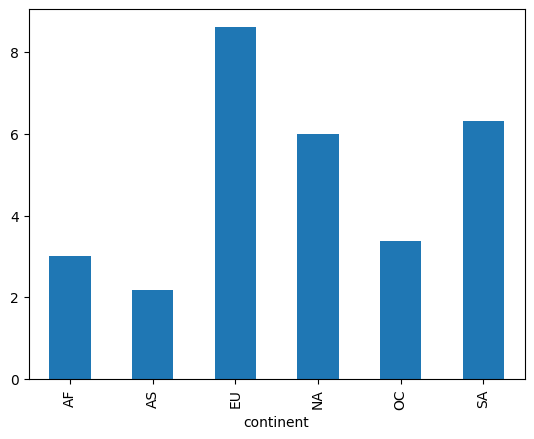

In [26]:
df.groupby('continent').mean()['total_litres_of_pure_alcohol'].plot(kind='bar')

### Mini Exercise - Visualization and Analysis
Create a simple plot (e.g., bar chart) using matplotlib to visualize the count of students in each department.

In [ ]:

# Sample data
data = {'Department': ['Engineering', 'Arts', 'Science'], 'Student Count': [30, 20, 25]}

# Creating DataFrame
df = pd.DataFrame(data)

# Plotting
df.plot(kind='bar', x='Department', y='Student Count')
plt.show()


### Mini Exercise - Database Management
Write a script to add a new column to an existing table (e.g., adding a 'gender' column to the 'students' table).

In [ ]:

# Connect to the database
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)
cur = conn.cursor()

# Add a new column 'gender' to the 'students' table
cur.execute(f"ALTER TABLE students_{STUDENT_NAME_TABLE} ADD COLUMN gender VARCHAR(10);")

# Commit changes
conn.commit()



# Close cursor and connection
cur.close()
conn.close()



## Final Exercise
Using the concepts learned in this notebook, perform the following tasks:
- Create a new table 'courses' with columns 'course_id', 'course_name', and 'student_id'.
- Insert sample data into the 'courses' table.
- Write a query to select all students who are taking more than one course.
- Use a GROUP BY clause to find the average age of students in each course.
- Implement pagination to display results in batches of 5.
- Finally, load the results into a Pandas DataFrame and create a simple plot.



Students taking more than one course: [(3, 2), (2, 2), (1, 2)]
Average age per course: [('Chemistry', Decimal('21.0000000000000000')), ('Mathematics', Decimal('21.5000000000000000')), ('History', Decimal('21.0000000000000000')), ('Physics', Decimal('22.0000000000000000')), ('Biology', Decimal('21.0000000000000000'))]
First batch of courses: [(1, 'Mathematics', 1), (2, 'Physics', 2), (3, 'Chemistry', 1), (4, 'Biology', 3), (5, 'Mathematics', 2)]


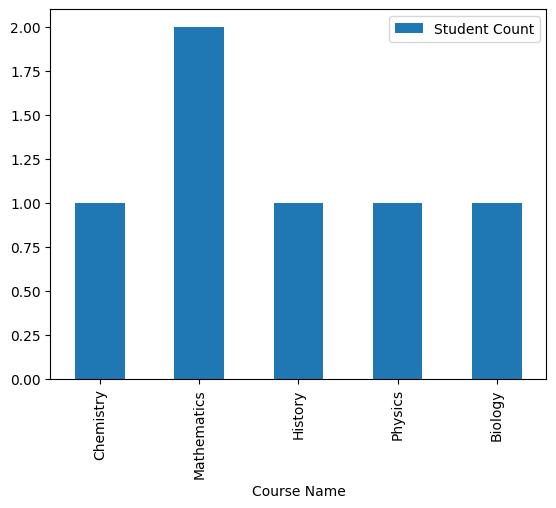

In [27]:

# Importing necessary libraries
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# Connect to your postgres DB
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)

# Open a cursor to perform database operations
cur = conn.cursor()

# Task 1: Create a new table 'courses'
cur.execute("DROP TABLE IF EXISTS courses;")
cur.execute("CREATE TABLE courses (course_id serial PRIMARY KEY, course_name VARCHAR (50), student_id INT);")

# Task 2: Insert sample data into the 'courses' table
sample_data = [
    ('Mathematics', 1),
    ('Physics', 2),
    ('Chemistry', 1),
    ('Biology', 3),
    ('Mathematics', 2),
    ('History', 3)
]

cur.executemany("INSERT INTO courses (course_name, student_id) VALUES (%s, %s);", sample_data)

# Commit changes
conn.commit()

# Task 3: Write a query to select all students who are taking more than one course
cur.execute("SELECT student_id, COUNT(*) FROM courses GROUP BY student_id HAVING COUNT(*) > 1;")
students_multiple_courses = cur.fetchall()
print("Students taking more than one course:", students_multiple_courses)

# Task 4: Use a GROUP BY clause to find the average age of students in each course
# For this, we need to join with the students table (assuming it exists and has an age column)
cur.execute(f"SELECT course_name, AVG(age) FROM courses JOIN students_{STUDENT_NAME_TABLE} ON courses.student_id = students_{STUDENT_NAME_TABLE}.id GROUP BY course_name;")
average_age_per_course = cur.fetchall()
print("Average age per course:", average_age_per_course)

# Task 5: Implement pagination to display results in batches of 5
cur.execute("SELECT * FROM courses LIMIT 5 OFFSET 0;")
first_batch = cur.fetchall()
print("First batch of courses:", first_batch)

# Task 6: Load the results into a Pandas DataFrame and create a simple plot
cur.execute("SELECT course_name, COUNT(*) as student_count FROM courses GROUP BY course_name;")
course_data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(course_data, columns=['Course Name', 'Student Count'])

# Plot
df.plot(kind='bar', x='Course Name', y='Student Count')
plt.show()

# Close cursor and connection
cur.close()
conn.close()

# Teardown

In [ ]:
conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD)
cursor = conn.cursor()

# Creating tables (drinks, countries, drink_reviews, ingredients, drink_ingredients)
cursor.execute(f"""
DROP TABLE IF EXISTS drinks_{STUDENT_NAME_TABLE} cascade;
DROP TABLE IF EXISTS students_{STUDENT_NAME_TABLE} cascade;
DROP TABLE IF EXISTS courses_{STUDENT_NAME_TABLE} cascade;
""")
conn.commit()
cursor.close()
conn.close()